In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import combinations
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Chapter 6 - Linear Model Selection and Regularization

## Ch6. Notes

The linear model has distinct advantages in terms of intference and, on real-world problems, is often surprisingly competitive in relation to non-linear methods. This chapter discussing some ways in which the simple linear model can be improved, by replacing plain least squares fitting with some alternative fitting procedures.

Why, you ask, might we want to use another fitting procedure instead of least squares? We will see that alternative fitting procedures can yield better *_prediction accuracy_* and *_model interpretability_*.

* **_Prediction Accuracy_**: Provided that the true relationship between the response and the predictors is approximately linear, the least squares estimates will have low bias. If *_n >> p_*, that is, the number of observations is much larger than variables, then the least squares estimates tend to also have low variance, and hence will perform well on test observations. *_However_*, if *_n_* is not much larger than *_p_*, then there can be a lot of variability in the least squares fit, resulting in overfitting and consequently poor predictions on future observations not used in model training. And if *_p > n_*, then there is no longer a unique least squares coefficient estimate: the variance is *_infinite_* so the method cannot be used at all. By **_constraining_** or **_shrinking_** the estimated coefficients, we can often substantially reduce the variance at the cost of a negligible increase in bias. This can lead to substantial improvements in the accuracy with which we can predict the response for observations not used in model training.

* **_Model Interpretability_**: It is often the case that some or many of the variables used in a multiple regression model are in fact not associated with the response. Including such *_irrelevant_* variables leads to unnecessary complexity in the resulting model. By removing these variables—that is, by setting the corresponding coefficient estimates to zero—we can obtain a model that is more easily interpreted. Now least squares is extremely unlikely to yield any coefficient estimates that are exactly zero. In this chapter, we see some approaches for automatically performing **_feature selection_** or **_variable selection_**—that is, for excluding irrelevant variables from a multiple regression model.

This chapter outlines three important classes of methods.

* **_Subset Selection_**: This approach involves identifying a subset of the *_p_* predictors that we believe to be related to the response. We then fit a model using least squares on the reduced set of variables.

* **_Shrinkage_**: This approach involves fitting a model involving all *_p_* predictors. However, the estimated coefficients are shrunken towards zero relative to the least squares estimates. This shrinkage (also known as **_regularization_**) has the effect of reducing variance. Depending on what type of shrinkage is performed, some of the coefficients may be estimated to be exactly zero. Hence, shrinkage methods can also perform variable selection.

* **_Dimension Reduction_**: This approach involves projecting the *_p_* predictors into a *_M_*-dimensional subspace, where *_M < p_*. This is achieved by computing *_M_* different **_linear combinations_**, or **_projections_**, of the variables. Then these *_M_* projections are used as predictors to fit a linear regression model by least squares.

**Best Subset Selection** considers $2^p$models. For exaple if *_p_*=10, then there are 1,000 possible models to consider and if *_p_*=20 there are over 1 million possibilities. Consequently, best subset selection becomes computationally infeasible for values of *_p_* greater than around 40, even with extremely fast modern computers.

Stepwise selection provides more computation feasible approaches.

**Forward Stepwise Selection** Considers $1+(p-k)$ models. Starts with a null model, containing no predictors. Then adds predictors incrementally that provide the greates additional improvement to the fit of the model. Best is defined as having smallest RSS or highest $R^2$. Can be used when $n<p$.

**Backward Stepwise Selection** also considers $1+(p-k)$ models. Starts with he full least squares model containing all *_p_* predictors, and the iteratively removes the least useful predictor, one-at-a-time. Requires $n>p$.

Though both forward and backward stepwise selection ten to do well in practice, neither are not guaranteed to yield the best model containing a subset of the *_p_* predictors. Basically, this is because stepwise contains the previous steps of selection, whereas the *_best_* model may not include the previous step.

**Choosing the optimal model** can be done with 2 common approaches:

1. We can **_indirectly_** estimate test error by making an *_adjustment_* to the training error to acount for the bias due to overfitting.
    1. Techniques for adjusting the training error fo the model size include: $C_p$, Akaike information criterion (AIC), Bayesian information criterion (BIC), and adjusted $R^2$.
2. We can *__directly__* estimate the test error, using either a validation set approach or a cross-validation approach.
    1. This procedure has an advantage relative to AIC, BIC, $C_p$, and adjusted $R^2$, in that it provides a direct estimate of the test error, and makes fewer assumptions about the true underlying model.
    
**Summary: choosing the optimal model directly or indirectly:**
In the past, performing cross-validation was computationally prohibitive for many problems with large $p$ and/or large $n$, and so AIC, BIC, $C_p$, and adjusted $R^2$ were more attractive approaches for choosing among a set of models. **However**, nowadays with fast computers, the computations required to perform cross-validation are hardly ever an issue. Thus, **_cross-validation is a very attractive approach for selecting from among a number of models under consideration_**.

### Shrinkage Methods

Subset selection methods involves using a subset of the full predictors. As an alternative, we can fit a model containing all $p$ predictors using a technique that *_constrains_* or *_regularizes_* the coefficient estimates, or equivalently, that *_shrinks_* the coefficient estimates toward zero.

It turns out that shrinking the coefficient estimates can significantly reduce their variance. The two best-known techniques for shrinking the regression coeffients towards zero are **_ridge regression_** and the **_lasso_**.



Both Ridge Regression and Lasso require standardized predictors. (For each predictor, subtract the mean and then divide by the standard deviation.)

#### Ridge Regression

Recall from Chapter 3 that the least squares fitting procedure estimates $\beta_0, \beta_1,...,\beta_p$ using the values that minimize:

$$RSS = \sum_{i=1}^n \left(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij} \right)^2$$

Ridge regession is very similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. The ridge regression coefficient estimates $\hat{\beta}^R$ are the values that minimize:

$$\sum_{i=1}^n \left(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij} \right)^2 + \lambda \sum_{j=1}^p \beta_j^2 = RSS + \lambda \sum_{j=1}^p \beta_j^2
$$

Where $\lambda >= 0$ is a tuning parameter, to be determined separately. 

As with least squared, ridge regression seeks coeffient estimates that fit the data well, by making the RSS small. However, the second term, $\lambda \sum_{j=1}^p \beta_j^2$, called a **_shrinkage penalty_** (L2 in ridge regression) is small when $\beta_1,...,\beta_p$ are close to zero, and so it has the effect of shrinking the estimates of $\beta_j$ towards zero.

When $\lambda=0$, the penalty term has no effect, and ridge regression will product the least squares estimates. However, as $\lambda\rightarrow \infty$, the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero.

There is a trade-off between the penalty term and RSS. Maybe a large $\beta$ would give you a better residual sum of squares but then it will push the penalty term higher. This is why you might actually prefer smaller $\beta$'s with worse residual sum of squares. From an optimization perspective, the penalty term  is equivalent to a constraint on the $\beta$'s.

#### The Lasso

Ridge regression will skrink the coefficients towards zero (as $\lambda\rightarrow \infty$), but will not *_equal_* zero. Lasso, on the other hand can zero out coefficients. This can lead to sparse models and can be interpreted as feature selection.

The lasso coefficients, $\hat{\beta^L}_\lambda$, minimize the quantity:

$$\sum_{i=1}^n \left(y_i - \beta_0 - \sum_{j=1}^p \beta_jx_{ij} \right)^2 + \lambda \sum_{j=1}^p \beta_j^2 = RSS + \lambda \sum_{j=1}^p |\beta_j|
$$

The lasso uses an L1 penalty instaed of an L2 penalty.

Regularization adds a bit of bias via the L1 or L2 penaltly, but gets greater improvement in the variance.

* **L1 penalty**
    * $\sum_{j=1}^p |\beta_j|$
    * the absolute value of the magnitude of the coefficients.
    * Manhattan distance
    * lasso - Least Absolute Shrinkage and Selection Operator


* **L2 penalty**
    * $\sum_{j=1}^p (\beta_j)^2$
    * the square of the magnitude of the coefficients.
    * Euclidian distance
    * ridge regression
    
Depending on the value of $\lambda$, the lasso can produce a model involving any number of variables. Wheras, ridge regression will always include all the variables in the model, although the magnitude of the coefficient estimates will depend on $\lambda$.

#### Selecting the tuning parameter $\lambda$
$\lambda$ is selected through cross-validation. We choose a grid of $\lambda$ values, and compute the cross-validation error for each value of $\lambda$. We then select the tuning parameter value for which the cross-validation error is smallest. Finally, the model is re-fit using all the available observations and the selected value of the tuning parameter.

#### Comparing the Lasso and Ridge Regression
* Lasso will perform better when a relatively small number of predictors have substantial coefficients, while the remaining predictors have very small coefficients. 
* Ridge regression will perform better when the response is a function of many predictors, all with coefficients of roughly equal size.

However, the number of predictors that is related to the response is never known a priori for real data sets. A technique such as cross-validation can be used in order to determine which approach is better on a particular data set.

#### The Variable Selection Property of the Lasso

The blue diamond and circle represent the lasso and ridge regression contraints respectively.

The ellipsess that are centered around $\hat{\beta}$ represent regions of constant RSS. All points on a given ellipse share a common value of the RSS.

if $\lambda=0$, then the constrain regions will contain $\hat{\beta}$. In this case, the least squared estimate lie outside the diamond and the circle. So the least squares estimate are not the same as the lasso and ridge regression estimates. (i.e. $\lambda>0$)

The lasso and ridge regression coefficient estimates are given by the first point at which an ellipse contact the constrain region (blue diamond and circle.)

* Since ridge regression has a circular constraint with no sharp points, this intersection will not generally occur on an axis, and so the ridge regression coefficient estimates will be exclusively non-zero.

* However, the lasso constraint has corners at each of the axes, and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coefficients will equal zero.

<img src="https://onlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson05/image_09/index.gif">

### Dimension Reduction Methods

Previous methods in this chapter controlled variance in two different ways, either using a subset of the original variables (best subset, forward/backward selection) or by shrinking their coefficients toward zero (ridge regression and lasso). All these methods are defined using the original predictors. There is also a class of approaches called **_dimension reduction_** methods. These, first *_transform_* the predictors, then fit a model using the transformed predictors.

#### Principal Components Analysis (PCA)

A popular approach for deriving a low-dimensional set of features from a large set of variables.

Successively maximize variance, subject to the constraint of being uncorrelated with the preceding components.

The first principal component $Z_1$ is the direction of the data is that along which the observations vary the most.

The second principal component $Z_2$ is a linear combination of the variables that is uncorrelated with $Z_1$, and has largest variance subject to this constraint. 

The zero correlation condition of $Z_1$ with $Z_2$ is equivalent to the condition that the direction must be *_perpendicular_* or *_orthogonal_*, to the first principal component direction.

Generally recommended to standardize each predictor prior to generating the principal components. If you don't standardize, the high-variance variables will play an outsized effect on the principal components obtained.

#### Principal Components Regression (PCR)

PCR involves constructing the first $M$ principal components, $Z_1,...,Z_M$, and then using these components as the predictors in a linear regression model that is fit using least squares.

Principal Components Regression will tend to do well in cases when the first few principal components are sufficient to capture most of the variation in the predictors as well as the relationship with the response. Otherwise, ridge or lasso may be better.


<img src="https://onlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson05/PCA_plot_02/index.gif">

#### Partial Least Squares (PLS)

A supervised alternative to PCR. The response $Y$ is used to help determine the principal component directions.

Makes use of the response $Y$ in order to identify new features that not only approximate the old features well, but also are related to the response.

PLS computes the first direction $Z_1$ by setting each loading equal to the coefficient from the simple linear regression of $Y$ onto $X_j$. PLS places the highest weight on the variables that are most strongly related to the response.

As with PCR, the number of $M$ partial least squares used in PLS is a tuning parameter typically chosen by cross-validation.

Generally, you standardize your predictors before performing PLS.

The overall benefit of PLS relative to PCR is a wash.

### Problems in High Dimensions

Data sets containing more features than observations $(n<p)$ are often referred to as *_high-dimensional_*.

In the high-dimensional setting least squares will overfit the data (a perfect fit) and the residuals will be zero.

The methods outlined in this chapter (stepwise selection, ridge regression, lasso, and PCA are useful for performing regression in the high-dimensional setting. These approaches avoid overfitting by using a less flexible approach than least squares.

**_Curse of dimensionality_**: i.e. more data can be a double edged sword. Adding additional signal features (variables) does not necessarily increase the accuracy of a model. Even if they are relevant, the variance incurred in fitting their coefficients may outweigh the reduction in bias that they bring.

In the high-dimensional setting, the multicollinearity problem is extreme.

Never use RSS, p_values, $R^2$ statistics, or other traditional measures of model fit on the training data as evidence of a good fit in the high-dimesnsional setting.

As we have learned by now, **__always evalute model performance on an independent test set or cross-validation__**.

## 6.5 Lab 1: Subset Selection Methods

In [57]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Hitters.csv', index_col=0)

In [58]:
df.index.name = 'Player'
print("Shape of dataframe: " + str(df.shape))
df.head()

Shape of dataframe: (322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


**Identify missing observations**

59 players missing 'Salary'.

In [59]:
# look at all variables for missing data
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [60]:
# look at only 'Salary' for missing data
df['Salary'].isnull().sum()

59

**Drop all the rows that have missing values in any variable**

In [61]:
df = df.dropna()
print("Shape of dataframe: " + str(df.shape))
df['Salary'].isnull().sum()

Shape of dataframe: (263, 20)


0

In [62]:
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


In [63]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

y = df.Salary
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


### 6.6.1 Ridge Regression

In [161]:
alphas = 10**np.linspace(10,-2,100)
alphas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

In [251]:
ridge = Ridge(normalize=True)
coefs = []
intercept = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)
    intercept.append(ridge.intercept_)
    
np.shape(coefs)

(100, 19)

In [252]:
alphas[49]

11497.569953977356

In [253]:
intercept[49]

535.9258821292775

In [254]:
pd.Series(coefs[49], index=X.columns)

AtBat          0.015450
Hits           0.017170
HmRun          0.013424
Runs           0.016433
RBI            0.017590
Walks          0.017373
Years          0.015679
CAtBat         0.020591
CHits          0.021482
CHmRun         0.020544
CRuns          0.022021
CRBI           0.022189
CWalks         0.019169
PutOuts        0.011763
Assists        0.000996
Errors        -0.000212
League_N      -0.000557
Division_W    -0.007537
NewLeague_N   -0.000110
dtype: float64

In [232]:
alphas[59]

705.4802310718645

In [233]:
intercept[60]

535.9258821292775

In [203]:
# smaller lambda = larger coefficients

pd.Series(coefs[59], index=X.columns)

AtBat          0.249440
Hits           0.277488
HmRun          0.216503
Runs           0.265459
RBI            0.283998
Walks          0.280735
Years          0.252749
CAtBat         0.332233
CHits          0.346754
CHmRun         0.331560
CRuns          0.355452
CRBI           0.358166
CWalks         0.309202
PutOuts        0.190661
Assists        0.016127
Errors        -0.003502
League_N      -0.008601
Division_W    -0.122422
NewLeague_N   -0.001450
dtype: float64

Text(0,0.5,'weights')

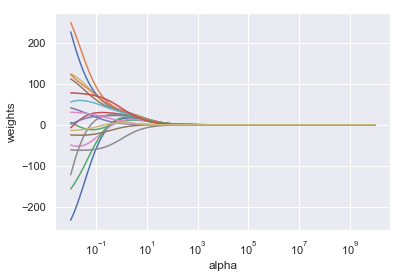

In [242]:
# plotting with 'normalization=True'
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

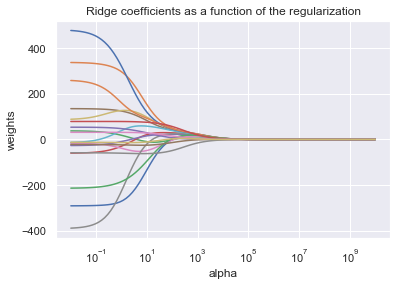

In [246]:
# plotting without normalization=True

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');